# 6. Análisis Multivariado

## Objetivo
Explorar estructuras complejas en los datos usando técnicas multivariadas:
- **PCA**: Reducción de dimensionalidad
- **Clustering**: Agrupamientos K-means y jerárquico
- **Correlaciones multivariadas**: Matriz de correlaciones
- **Análisis de Varianza Multivariado (MANOVA)**: Diferencias entre grupos

---

## 6.0 Configuración e Importaciones

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configuracion de visualizacion
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['axes.labelsize'] = 11

# Paleta de colores
COLORS = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#3B1F2B', '#1B998B', '#E84855']
sns.set_palette(COLORS)

In [40]:
# Cargar dataset limpio
DATA_PATH = Path('../data/processed')
df = pd.read_csv(DATA_PATH / 'nacimientos_2009_2022_limpio.csv')

print(f"Dataset cargado: {len(df):,} registros | {len(df.columns)} variables")

Dataset cargado: 5,195,195 registros | 36 variables


In [41]:
# Crear mappings para variables categoricas
mapping_estado_civil = {
    1.0: 'Unida', 2.0: 'Casada', 3.0: 'Soltera',
    4.0: 'Divorciada', 5.0: 'Viuda', 6.0: 'Separada', 9.0: 'Ignorado'
}

mapping_departamentos = {
    1.0: 'Guatemala', 2.0: 'El Progreso', 3.0: 'Sacatepequez',
    4.0: 'Chimaltenango', 5.0: 'Escuintla', 6.0: 'Santa Rosa',
    7.0: 'Solola', 8.0: 'Totonicapan', 9.0: 'Quetzaltenango',
    10.0: 'Suchitepequez', 11.0: 'Retalhuleu', 12.0: 'San Marcos',
    13.0: 'Huehuetenango', 14.0: 'Quiche', 15.0: 'Baja Verapaz',
    16.0: 'Alta Verapaz', 17.0: 'Peten', 18.0: 'Izabal',
    19.0: 'Zacapa', 20.0: 'Chiquimula', 21.0: 'Jalapa', 22.0: 'Jutiapa'
}

# Aplicar mappings
df['Estado_civil'] = df['Escivm'].map(mapping_estado_civil).fillna('Desconocido')
df['Departamento'] = df['Deprem'].map(mapping_departamentos).fillna('Desconocido')

---
## 6.1 Preparación de Datos para Análisis Multivariado

In [42]:
# Seleccionar variables numericas relevantes para analisis multivariado
# OPCIÓN 2: Substitución moderada - Geografía + Demografía
variables_foco = [
    'Edadm',            # Edad de la madre (demográfico)
    'Peso_gramos',      # Peso al nacer en gramos (desenlace principal)
    'Deprem',           # Departamento de residencia de la madre (GEOGRAFÍA)
    'Tohite',           # Total de hijos tenidos (demográfico)
    'Sexo',             # Sexo del recién nacido (0=Mujer, 1=Hombre)
    'Tipar',            # Tipo de parto (1=Normal, 2=Cesárea)
    'Depreg',           # Departamento de registro (GEOGRAFÍA)
]

# Parametros para graficas menos cargadas
MAX_MUESTRA_GRAFICOS = 20000
RANDOM_STATE = 42
rng = np.random.default_rng(RANDOM_STATE)

# Verificar disponibilidad
variables_disponibles = [v for v in variables_foco if v in df.columns]
faltantes = [v for v in variables_foco if v not in df.columns]

if faltantes:
    print(f"⚠️ Variables no encontradas: {faltantes}")
    print(f"   Se utilizarán solo las variables disponibles")
if len(variables_disponibles) < 2:
    raise ValueError("Insuficientes variables para analisis multivariado")

# Crear dataset y eliminar valores faltantes
df_analisis_limpio = df[variables_disponibles].dropna()

print(f"✓ Variables seleccionadas: {len(variables_disponibles)}")
print(f"  {', '.join(variables_disponibles)}")
print(f"\n✓ Registros validos (sin NA): {len(df_analisis_limpio):,}")

✓ Variables seleccionadas: 7
  Edadm, Peso_gramos, Deprem, Tohite, Sexo, Tipar, Depreg

✓ Registros validos (sin NA): 5,107,381


In [43]:
# Estadisticas descriptivas
df_analisis_limpio.describe()

,Edadm,Peso_gramos,Deprem,Tohite,Sexo,Tipar,Depreg
count,5.107381e+06,5.107381e+06,5.107381e+06,5.107381e+06,5.107381e+06,5.107381e+06,5.107381e+06
mean,2.563847e+01,3.055892e+03,1.053197e+01,2.646245e+00,1.492038e+00,1.012124e+00,1.045200e+01
std,6.593610e+00,4.940601e+02,6.295137e+00,2.007297e+00,4.999367e-01,1.115167e-01,6.255640e+00
min,1.000000e+01,5.102910e+02,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,2.000000e+01,2.721552e+03,5.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,5.000000e+00
50%,2.500000e+01,3.090095e+03,1.200000e+01,2.000000e+00,1.000000e+00,1.000000e+00,1.200000e+01
75%,3.000000e+01,3.345241e+03,1.600000e+01,3.000000e+00,2.000000e+00,1.000000e+00,1.600000e+01
max,5.500000e+01,5.726599e+03,9.900000e+01,1.900000e+01,2.000000e+00,4.000000e+00,2.200000e+01


In [44]:
# Estandarizar datos (necesario para PCA y Clustering)
scaler = StandardScaler()
df_escalado = scaler.fit_transform(df_analisis_limpio)
df_escalado = pd.DataFrame(df_escalado, columns=variables_disponibles)

---
## 6.2 Matriz de Correlaciones

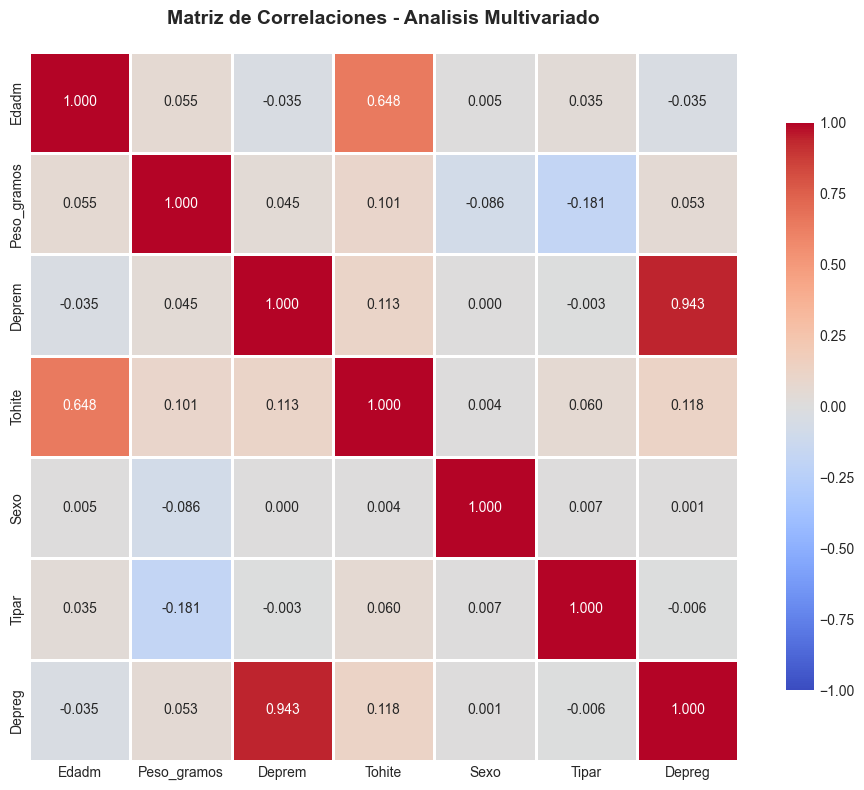

In [45]:
# Calcular matriz de correlaciones
correlacion = df_analisis_limpio.corr(method='pearson')

# Visualizar
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(correlacion, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1, ax=ax)
plt.title('Matriz de Correlaciones - Analisis Multivariado', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('../data/processed/06_matriz_correlaciones.png', dpi=300, bbox_inches='tight')
plt.show()

---
## 6.3 Análisis de Componentes Principales (PCA)

In [46]:
# Aplicar PCA
pca_full = PCA()
pca_full.fit(df_escalado)

# Varianza explicada
var_acumulada = np.cumsum(pca_full.explained_variance_ratio_)

# Mostrar resultados
print("Varianza explicada por componente:")
for i, var in enumerate(pca_full.explained_variance_ratio_, 1):
    print(f"  PC{i}: {var*100:.2f}%")

print(f"\nVarianza acumulada PC1-PC2: {var_acumulada[1]*100:.2f}%")
print(f"Componentes para 80% varianza: {np.argmax(var_acumulada >= 0.8) + 1}")

Varianza explicada por componente:
  PC1: 28.38%
  PC2: 23.48%
  PC3: 17.11%
  PC4: 14.20%
  PC5: 11.23%
  PC6: 4.79%
  PC7: 0.81%

Varianza acumulada PC1-PC2: 51.86%
Componentes para 80% varianza: 4


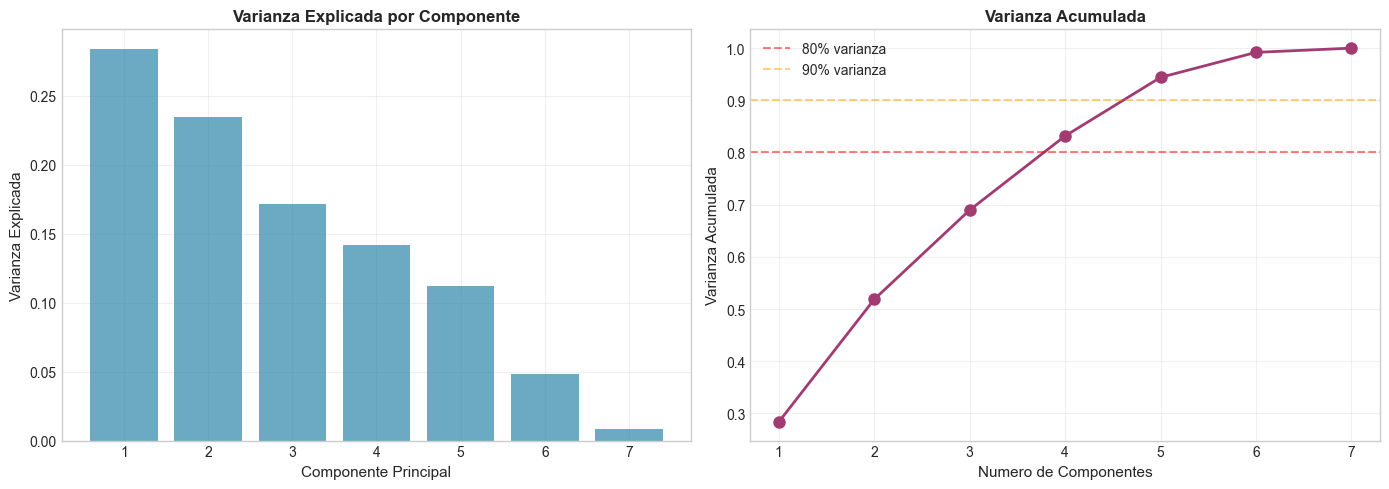

In [47]:
# Grafico: Varianza explicada
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Varianza individual
ax1.bar(range(1, len(pca_full.explained_variance_ratio_)+1), 
        pca_full.explained_variance_ratio_, alpha=0.7, color='#2E86AB')
ax1.set_xlabel('Componente Principal', fontsize=11)
ax1.set_ylabel('Varianza Explicada', fontsize=11)
ax1.set_title('Varianza Explicada por Componente', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Varianza acumulada
ax2.plot(range(1, len(var_acumulada)+1), var_acumulada, 'o-', 
         linewidth=2, markersize=8, color='#A23B72')
ax2.axhline(y=0.8, color='red', linestyle='--', alpha=0.5, label='80% varianza')
ax2.axhline(y=0.9, color='orange', linestyle='--', alpha=0.5, label='90% varianza')
ax2.set_xlabel('Numero de Componentes', fontsize=11)
ax2.set_ylabel('Varianza Acumulada', fontsize=11)
ax2.set_title('Varianza Acumulada', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../data/processed/06_pca_varianza.png', dpi=300, bbox_inches='tight')
plt.show()

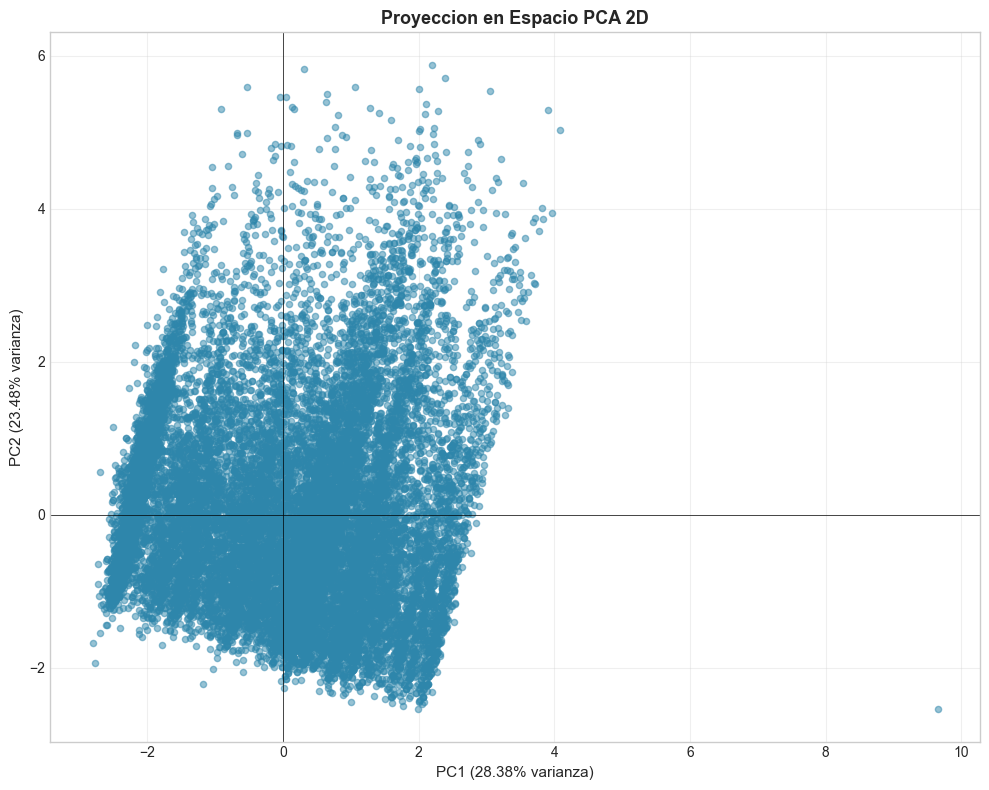

In [48]:
# PCA con 2 componentes para visualizacion
pca_2d = PCA(n_components=2)
pca_scores_2d = pca_2d.fit_transform(df_escalado)

# Muestra para grafica
idx_plot = rng.choice(len(df_escalado), size=min(MAX_MUESTRA_GRAFICOS, len(df_escalado)), replace=False)
pca_scores_2d_plot = pca_scores_2d[idx_plot]

# Grafico de dispersion
plt.figure(figsize=(10, 8))
plt.scatter(pca_scores_2d_plot[:, 0], pca_scores_2d_plot[:, 1], alpha=0.5, s=20, color='#2E86AB')
plt.xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.2f}% varianza)', fontsize=11)
plt.ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.2f}% varianza)', fontsize=11)
plt.title('Proyeccion en Espacio PCA 2D', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='k', linewidth=0.5)
plt.axvline(x=0, color='k', linewidth=0.5)
plt.tight_layout()
plt.savefig('../data/processed/06_pca_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

,PC1,PC2
Edadm,0.119245,0.693820
Peso_gramos,0.100865,0.114428
Deprem,0.675744,-0.190142
Tohite,0.246605,0.655182
Sexo,-0.006418,-0.005874
Tipar,-0.005223,0.069576
Depreg,0.676826,-0.187691


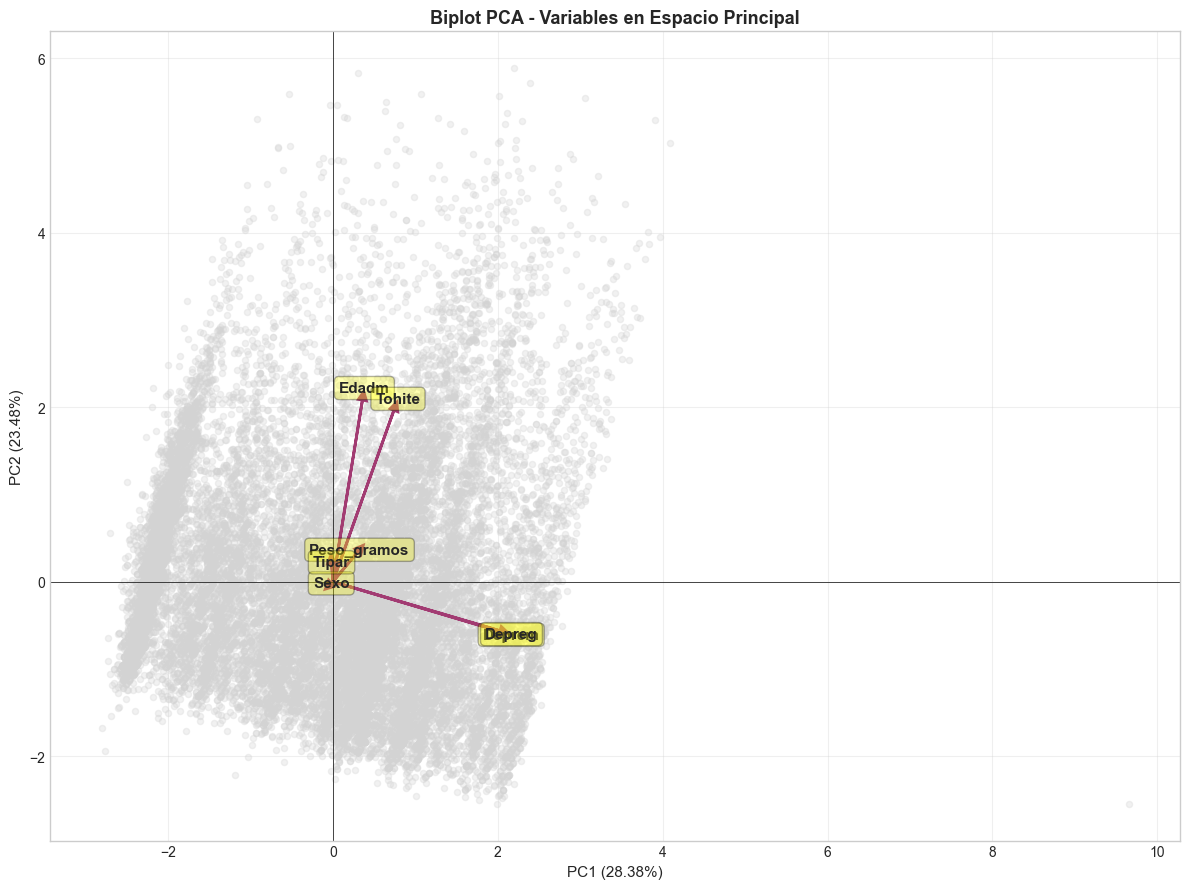

In [49]:
# Loadings: Contribucion de variables a PC1 y PC2
loadings = pd.DataFrame(
    pca_2d.components_.T,
    columns=['PC1', 'PC2'],
    index=variables_disponibles
)
display(loadings)

# Biplot
fig, ax = plt.subplots(figsize=(12, 9))

# Scatter de muestra
ax.scatter(pca_scores_2d_plot[:, 0], pca_scores_2d_plot[:, 1], alpha=0.3, s=20, color='lightgray')

# Vectores de variables
for i, var in enumerate(variables_disponibles):
    ax.arrow(0, 0, pca_2d.components_[0, i]*3, pca_2d.components_[1, i]*3,
             head_width=0.1, head_length=0.1, fc='#A23B72', ec='#A23B72', linewidth=2)
    ax.text(pca_2d.components_[0, i]*3.2, pca_2d.components_[1, i]*3.2, var, 
            fontsize=11, fontweight='bold', ha='center', va='center',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3))

ax.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.2f}%)', fontsize=11)
ax.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.2f}%)', fontsize=11)
ax.set_title('Biplot PCA - Variables en Espacio Principal', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='k', linewidth=0.5)
ax.axvline(x=0, color='k', linewidth=0.5)
plt.tight_layout()
plt.savefig('../data/processed/06_pca_biplot.png', dpi=300, bbox_inches='tight')
plt.show()

---
## 6.4 Clustering K-Means

In [50]:
# Encontrar número óptimo de clusters (método del codo)
print("═" * 70)
print("CLUSTERING K-MEANS - DETERMINACIÓN DE CLUSTERS ÓPTIMOS")
print("═" * 70)

# Usar muestra para evaluación (por performance con dataset grande)
muestra_idx = np.random.choice(df_escalado.shape[0], size=min(50000, df_escalado.shape[0]), replace=False)
df_muestra_eval = df_escalado.iloc[muestra_idx]
print(f"\nUsando muestra de {len(df_muestra_eval):,} registros para evaluación")

inertias = []
silhouette_scores = []
davies_bouldin_scores = []
K_range = range(2, 11)

for k in K_range:
    # Entrenar en muestra
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_temp.fit(df_muestra_eval)
    inertias.append(kmeans_temp.inertia_)
    silhouette_scores.append(silhouette_score(df_muestra_eval, kmeans_temp.labels_))
    davies_bouldin_scores.append(davies_bouldin_score(df_muestra_eval, kmeans_temp.labels_))

# Mostrar resultados
print(f"\n{'K':<5} {'Inercia':<15} {'Silhouette':<15} {'Davies-Bouldin':<15}")
print("─" * 55)
for i, k in enumerate(K_range):
    print(f"{k:<5} {inertias[i]:<15.2f} {silhouette_scores[i]:<15.4f} {davies_bouldin_scores[i]:<15.4f}")

══════════════════════════════════════════════════════════════════════
CLUSTERING K-MEANS - DETERMINACIÓN DE CLUSTERS ÓPTIMOS
══════════════════════════════════════════════════════════════════════

Usando muestra de 50,000 registros para evaluación

K     Inercia         Silhouette      Davies-Bouldin 
───────────────────────────────────────────────────────
2     279423.78       0.2282          1.7023         
3     236129.99       0.2369          1.5055         
4     184628.29       0.2511          1.1913         
5     160045.67       0.2498          1.1636         
6     143029.06       0.2537          1.2443         
7     134783.07       0.2381          1.3123         
8     126660.50       0.2362          1.3504         
9     120104.14       0.2291          1.3313         
10    114078.39       0.2336          1.2630         


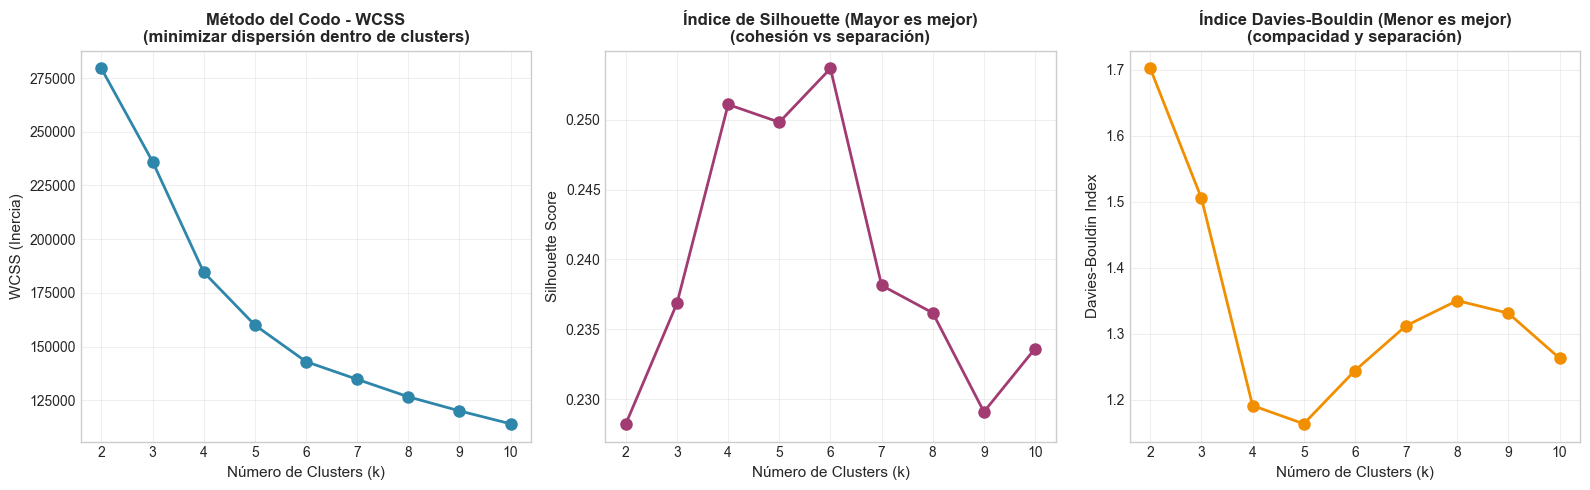


✓ Gráficos de evaluación guardados

📊 EXPLICACIÓN DE MÉTRICAS:
  • WCSS: Suma de distancias cuadráticas dentro de cada cluster
  • Silhouette: Mide qué bien asignada está cada punto (-1 a 1)
  • Davies-Bouldin: Promedio de similitud cluster-to-cluster


In [51]:
# Gráficos de evaluación de clusters
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Elbow - WCSS (Within-Cluster Sum of Squares)
axes[0].plot(K_range, inertias, 'o-', linewidth=2, markersize=8, color='#2E86AB')
axes[0].set_xlabel('Número de Clusters (k)', fontsize=11)
axes[0].set_ylabel('WCSS (Inercia)', fontsize=11)
axes[0].set_title('Método del Codo - WCSS\n(minimizar dispersión dentro de clusters)', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Silhouette
axes[1].plot(K_range, silhouette_scores, 'o-', linewidth=2, markersize=8, color='#A23B72')
axes[1].set_xlabel('Número de Clusters (k)', fontsize=11)
axes[1].set_ylabel('Silhouette Score', fontsize=11)
axes[1].set_title('Índice de Silhouette (Mayor es mejor)\n(cohesión vs separación)', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Davies-Bouldin
axes[2].plot(K_range, davies_bouldin_scores, 'o-', linewidth=2, markersize=8, color='#F18F01')
axes[2].set_xlabel('Número de Clusters (k)', fontsize=11)
axes[2].set_ylabel('Davies-Bouldin Index', fontsize=11)
axes[2].set_title('Índice Davies-Bouldin (Menor es mejor)\n(compacidad y separación)', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../data/processed/06_kmeans_evaluacion.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Gráficos de evaluación guardados")
print("\n📊 EXPLICACIÓN DE MÉTRICAS:")
print("  • WCSS: Suma de distancias cuadráticas dentro de cada cluster")
print("  • Silhouette: Mide qué bien asignada está cada punto (-1 a 1)")
print("  • Davies-Bouldin: Promedio de similitud cluster-to-cluster")

In [58]:
# Usar k=4 (mejor Silhouette=0.2511 y Davies-Bouldin=1.1913 según evaluación)
k_optimo = 4
kmeans = KMeans(n_clusters=k_optimo, random_state=42, n_init=10)
clusters = kmeans.fit_predict(df_escalado)

print(f"\nClustering realizado con k={k_optimo}")
print(f"Distribución de clusters: {pd.Series(clusters).value_counts().sort_index().to_dict()}")

# Calcular silhouette en muestra (más rápido)
muestra_idx_sil = np.random.choice(len(df_escalado), size=min(50000, len(df_escalado)), replace=False)
silhouette_muestra = silhouette_score(df_escalado.iloc[muestra_idx_sil], clusters[muestra_idx_sil])
print(f"Silhouette Score (muestra de 50k): {silhouette_muestra:.4f}")


Clustering realizado con k=4
Distribución de clusters: {0: 2258871, 1: 1824614, 2: 963053, 3: 60843}
Silhouette Score (muestra de 50k): 0.2524


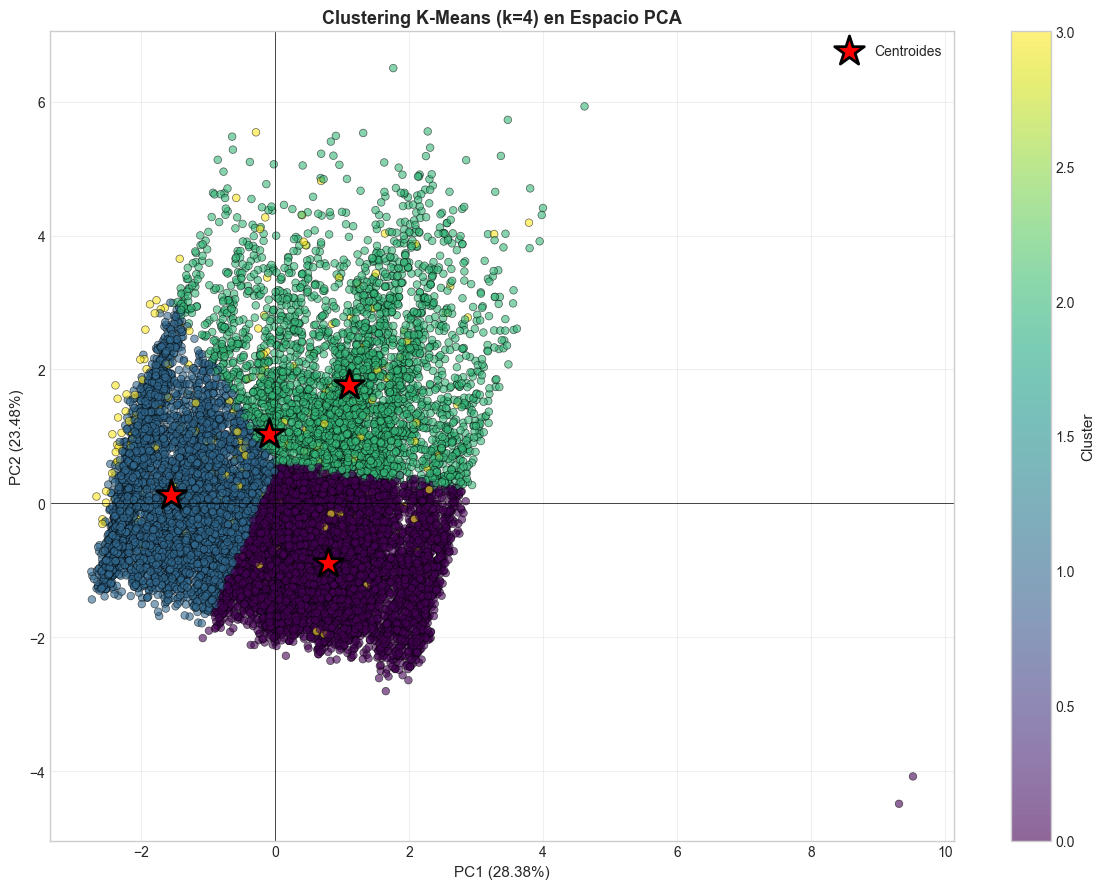

✓ Visualizacion de clusters guardada


In [59]:
# Visualizacion de clusters en espacio PCA
idx_plot = rng.choice(len(df_escalado), size=min(MAX_MUESTRA_GRAFICOS, len(df_escalado)), replace=False)
pca_scores_2d_plot = pca_scores_2d[idx_plot]
clusters_plot = clusters[idx_plot]

plt.figure(figsize=(12, 9))
scatter = plt.scatter(pca_scores_2d_plot[:, 0], pca_scores_2d_plot[:, 1], 
                       c=clusters_plot, cmap='viridis', s=30, alpha=0.6, edgecolors='black', linewidth=0.5)

# Centroides en espacio PCA
centroides_pca = pca_2d.transform(kmeans.cluster_centers_)
plt.scatter(centroides_pca[:, 0], centroides_pca[:, 1], 
            c='red', marker='*', s=500, edgecolors='black', linewidth=2, label='Centroides')

plt.xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.2f}%)', fontsize=11)
plt.ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.2f}%)', fontsize=11)
plt.title(f'Clustering K-Means (k={k_optimo}) en Espacio PCA', fontsize=13, fontweight='bold')
plt.colorbar(scatter, label='Cluster')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='k', linewidth=0.5)
plt.axvline(x=0, color='k', linewidth=0.5)
plt.tight_layout()
plt.savefig('../data/processed/06_kmeans_clusters.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualizacion de clusters guardada")

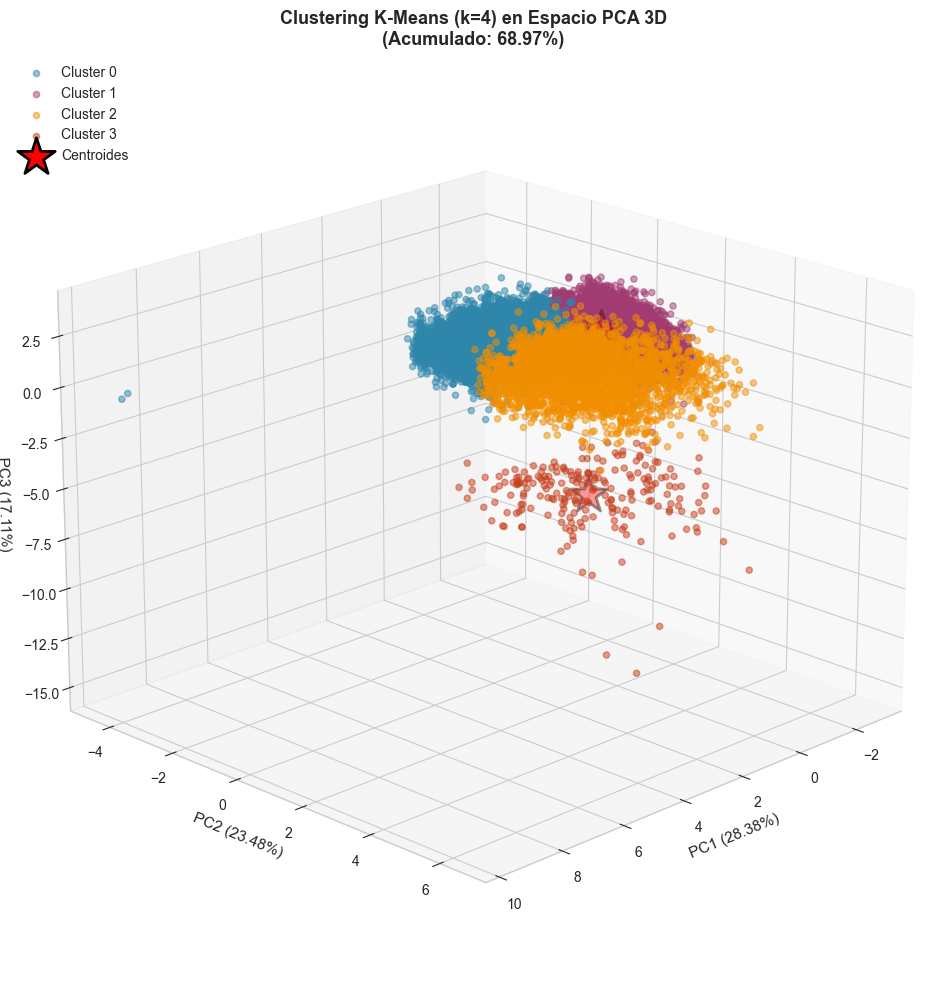

✓ Visualizacion 3D de clusters guardada

📊 Varianza en 3D:
  • PC1: 28.38%
  • PC2: 23.48%
  • PC3: 17.11%
  • Acumulada: 68.97%


In [62]:
from mpl_toolkits.mplot3d import Axes3D

# PCA con 3 componentes para visualizacion 3D
pca_3d = PCA(n_components=3)
pca_scores_3d = pca_3d.fit_transform(df_escalado)

# Muestra para grafica 3D (usar la misma que 2D para consistencia)
pca_scores_3d_plot = pca_scores_3d[idx_plot]

# Grafico 3D interactivo
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter por cluster
for cluster_id in range(k_optimo):
    mask = clusters_plot == cluster_id
    ax.scatter(pca_scores_3d_plot[mask, 0], 
               pca_scores_3d_plot[mask, 1],
               pca_scores_3d_plot[mask, 2],
               c=[COLORS[cluster_id]], s=20, alpha=0.5, label=f'Cluster {cluster_id}')

# Centroides en espacio 3D
centroides_pca3d = pca_3d.transform(kmeans.cluster_centers_)
ax.scatter(centroides_pca3d[:, 0], centroides_pca3d[:, 1], centroides_pca3d[:, 2],
           c='red', marker='*', s=800, edgecolors='black', linewidth=2, label='Centroides')

ax.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]*100:.2f}%)', fontsize=11)
ax.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]*100:.2f}%)', fontsize=11)
ax.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]*100:.2f}%)', fontsize=11)
ax.set_title(f'Clustering K-Means (k={k_optimo}) en Espacio PCA 3D\n(Acumulado: {sum(pca_3d.explained_variance_ratio_)*100:.2f}%)', 
             fontsize=13, fontweight='bold')
ax.legend(loc='upper left')

# Rotar vista para mejor visualizacion
ax.view_init(elev=20, azim=45)

plt.tight_layout()
plt.savefig('../data/processed/06_kmeans_clusters_3d.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualizacion 3D de clusters guardada")
print(f"\n📊 Varianza en 3D:")
print(f"  • PC1: {pca_3d.explained_variance_ratio_[0]*100:.2f}%")
print(f"  • PC2: {pca_3d.explained_variance_ratio_[1]*100:.2f}%")
print(f"  • PC3: {pca_3d.explained_variance_ratio_[2]*100:.2f}%")
print(f"  • Acumulada: {sum(pca_3d.explained_variance_ratio_)*100:.2f}%")

---
## 6.5 Clustering Jerárquico

In [54]:
# Clustering jerárquico con matriz de distancias reducida (por performance)
print("═" * 70)
print("CLUSTERING JERÁRQUICO")
print("═" * 70)

# Usar una muestra para el dendrograma (datos grandes)
muestra_indices = np.random.choice(df_escalado.shape[0], size=min(1000, df_escalado.shape[0]), replace=False)
df_muestra = df_escalado.iloc[muestra_indices]

print(f"\nUsando muestra de {len(df_muestra):,} registros para análisis jerárquico")

# Calcular matriz de distancias y clustering
linkage_matrix = linkage(df_muestra, method='ward')
print("✓ Matriz de ligamento calculada")

══════════════════════════════════════════════════════════════════════
CLUSTERING JERÁRQUICO
══════════════════════════════════════════════════════════════════════

Usando muestra de 1,000 registros para análisis jerárquico
✓ Matriz de ligamento calculada


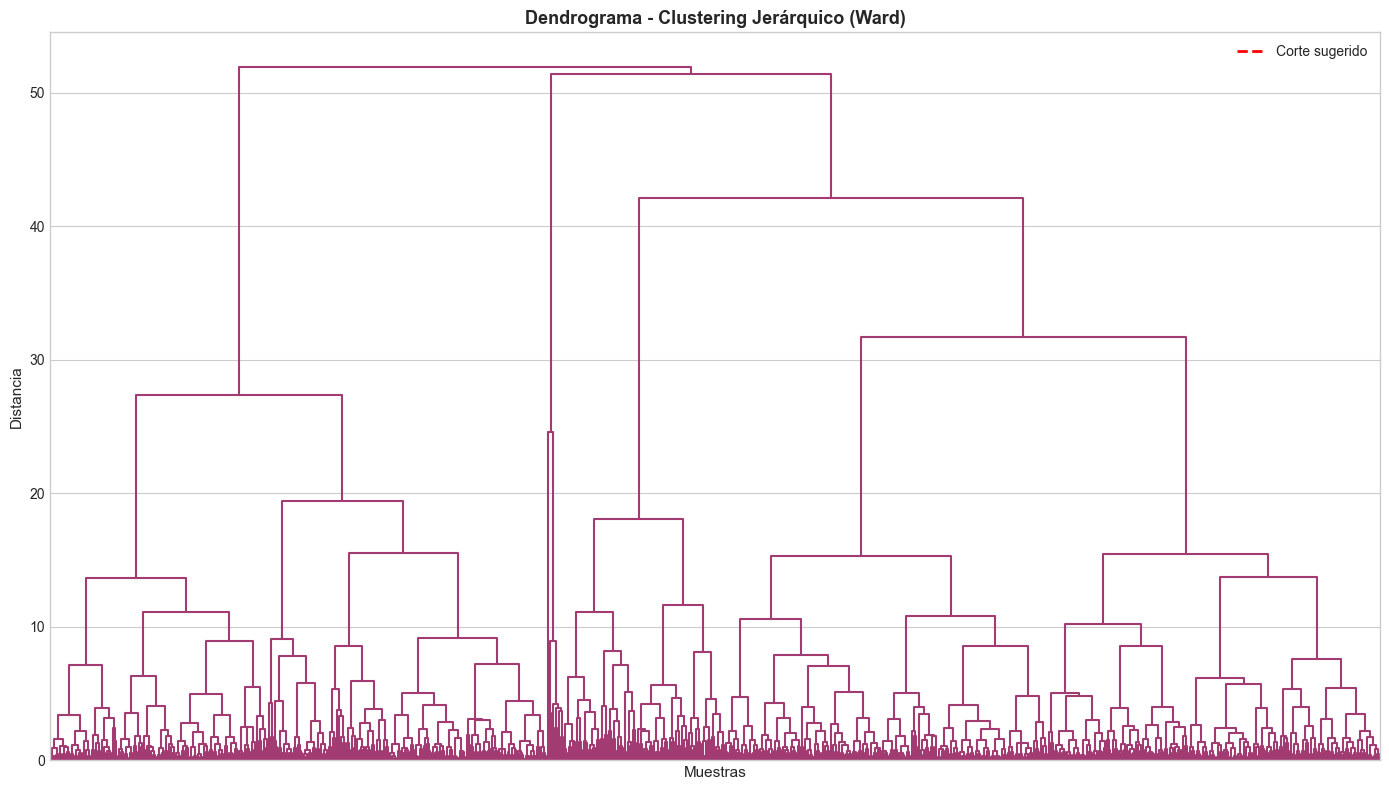

✓ Dendrograma guardado


In [55]:
# Dendrograma
plt.figure(figsize=(14, 8))
dendrogram(linkage_matrix, 
           no_labels=True,
           color_threshold=100,
           above_threshold_color='gray')
plt.xlabel('Muestras', fontsize=11)
plt.ylabel('Distancia', fontsize=11)
plt.title('Dendrograma - Clustering Jerárquico (Ward)', fontsize=13, fontweight='bold')
plt.axhline(y=100, color='red', linestyle='--', label='Corte sugerido', linewidth=2)
plt.legend()
plt.tight_layout()
plt.savefig('../data/processed/06_dendrograma.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Dendrograma guardado")

---
## 6.6 Resumen de Hallazgos

In [60]:
# Resumen de análisis multivariado
print("═" * 70)
print("RESUMEN - ANÁLISIS MULTIVARIADO")
print("═" * 70)

print("\n📊 PCA (Análisis de Componentes Principales):")
print(f"  • PC1 explica: {pca_full.explained_variance_ratio_[0]*100:.2f}% de la varianza")
print(f"  • PC1+PC2 explican: {(pca_full.explained_variance_ratio_[0] + pca_full.explained_variance_ratio_[1])*100:.2f}% de la varianza")
print(f"  • Se necesitan {np.argmax(var_acumulada >= 0.8) + 1} componentes para explicar 80% de varianza")

print("\n🔗 Clustering K-Means:")
print(f"  • Clusters óptimo: {k_optimo}")
print(f"  • Silhouette Score (muestra): {silhouette_muestra:.4f}")
print(f"  • Distribución: ")
for cluster_id in range(k_optimo):
    count = (clusters == cluster_id).sum()
    pct = count / len(clusters) * 100
    print(f"    - Cluster {cluster_id}: {count:,} registros ({pct:.2f}%)")

print("\n📈 Correlaciones:")
max_corr = correlacion.values[np.triu_indices_from(correlacion.values, k=1)].max()
min_corr = abs(correlacion.values[np.triu_indices_from(correlacion.values, k=1)]).min()
print(f"  • Correlaciones máxima (absoluto): {max_corr:.4f}")
print(f"  • Correlaciones mínima (absoluto): {min_corr:.4f}")

print("\n✓ Análisis multivariado completado exitosamente")


══════════════════════════════════════════════════════════════════════
RESUMEN - ANÁLISIS MULTIVARIADO
══════════════════════════════════════════════════════════════════════

📊 PCA (Análisis de Componentes Principales):
  • PC1 explica: 28.38% de la varianza
  • PC1+PC2 explican: 51.86% de la varianza
  • Se necesitan 4 componentes para explicar 80% de varianza

🔗 Clustering K-Means:
  • Clusters óptimo: 4
  • Silhouette Score (muestra): 0.2524
  • Distribución: 
    - Cluster 0: 2,258,871 registros (44.23%)
    - Cluster 1: 1,824,614 registros (35.73%)
    - Cluster 2: 963,053 registros (18.86%)
    - Cluster 3: 60,843 registros (1.19%)

📈 Correlaciones:
  • Correlaciones máxima (absoluto): 0.9430
  • Correlaciones mínima (absoluto): 0.0004

✓ Análisis multivariado completado exitosamente


In [61]:
# Guardar resultados en metadatos
import json

metadatos_multivariado = {
    "analisis": "Multivariado",
    "fecha_ejecucion": pd.Timestamp.now().isoformat(),
    "pca": {
        "componentes_totales": len(pca_full.explained_variance_ratio_),
        "varianza_pc1": float(pca_full.explained_variance_ratio_[0]),
        "varianza_pc2": float(pca_full.explained_variance_ratio_[1]),
        "varianza_acumulada_2": float(var_acumulada[1]),
        "componentes_para_80pct": int(np.argmax(var_acumulada >= 0.8) + 1)
    },
    "kmeans": {
        "k_optimo": int(k_optimo),
        "silhouette_score_muestra": float(silhouette_muestra),
        "distribucion_clusters": {str(i): int(np.sum(clusters == i)) for i in range(k_optimo)}
    },
    "variables_analizadas": variables_disponibles,
    "registros_analizados": int(len(df_escalado))
}

with open(DATA_PATH / 'metadatos_multivariado.json', 'w') as f:
    json.dump(metadatos_multivariado, f, indent=2)

print("✓ Metadatos guardados en 'metadatos_multivariado.json'")


✓ Metadatos guardados en 'metadatos_multivariado.json'
